# DC2 Image Analysis, 511 keV, Data Reduction

updated on 2024-01-30 (the commit 26cfdeacb25335bd511a91c4f8a29bdeb36408f2)

This notebook focuses on how to produce the binned datasets with the spacecraft attitude (scatt) binning method for DC2.
Using the 511keV thin disk 3-month simulation data created for DC2, an example of the image analysis will be presented.
After running through this notebook, you can go to the next notebook, 511keV-DC2-ScAtt-ImageDeconvolution.ipynb.

### Notes on the coordinate system of Compton data space in the image deconvolution ###

We have two options on the coordinate system to describe the Compton scattering direction ($\chi\psi$) with, namely the Galactic coordinate or the detector coordinate.

Using the Galactic coordinate is intuitive, and the spectral fitting adopts this coordinate. Thus, we suppose that Galactic coordinate should be adopted also for image deconvolution eventually. However, in this case, we need to convert the detector response into the Galactic coordinate for each pixel in the sky because the response matrix is described in the detector coordinate. As for now, it takes a long time to compute it. Thus, the pre-computed converted response are provided in DC2 for several main sources (511 keV, Al-26, Ti-44, continuum). The pre-computed responses assume that we analyze 3-month data without extracting some time intervals, and the pixel resolution of the model map is already fixed in them. While there is less flexibility in binning/modeling, it is relatively fast to perform the image deconvolution in DC2 since the most computationally heavy part, the coordinate conversion of the response, can be skipped.

Using the detector coordinates for Compton data space may not be so intuitive. However, the advantage is that we do not have to convert the response matrix. Instead, we will convert the model map into the detector coordinate. Because the model map generally has a much smaller data size than the response, we can compute this coordinate conversion quickly. 

The disadvantage of this method is that we need more bins due to continuous pointing changes of the COSI satellite. Since COSI is an all-sky monitoring satellite with ∼90-minute orbits, it changes its pointing by ∼4 degrees every minute. Thus, in this case, we need to divide the data into several bins so that astronomical sources can be considered at rest in the detector coordinate for each bin within the COSI's angular resolution. The straightforward way could be to divide the data every $\sim$15 seconds, considering that the COSI's angular resolution is an order of degrees. However, we need $5\times10^5$ time bins for 3-month observations, which makes the event histogram very huge. To avoid this issue, the spacecraft attitude (scatt) binning method is introduced. Instead of binning data over time, we first analyze the satellite attitude and find the time intervals when the satellite has almost the same attitude within the angular resolution. Then, we assign the events in such intervals into the same CDS. In the DC2 simulation, the orbit inclination is assumed to be 0 degrees. In this case, the number of the scatt bins becomes 100-1000, which makes the computation more executable. With this method, at least in DC2, we can perform the image deconvolution using the original response matrix and have flexibilities to change binning/modeling, e.g., the pixel resolution can be changed in a relatively easy way.

While both methods have pros and cons, our baseline is to eventually use the Galactic coordinate. But we still need to carefully investigate how they will be scaled with longer exposure, finer pixel resolution, etc. Thus, we provide the notebooks of both methods for the image deconvolution in DC2.

For the Crab image analysis, the following notebooks are based on the scatt binning method
- ScAttBinning/511keV-DC2-ScAtt-DataReduction.ipynb
- ScAttBinning/511keV-DC2-ScAtt-ImageDeconvolution.ipynb
- ScAttBinning/511keV-DC2-ScAtt-Upsampling.ipynb

GalacticCDS/511keV-DC2-Galactic-ImageDeconvolution.ipynb uses the galactic coordinate.

If you want to know about the other analysis, e.g., the spectral analysis, you can see the notebooks in docs/tutorials/spectral_fits.

In [1]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from tqdm.autonotebook import tqdm

Welcome to JupyROOT 6.24/06


19:20:46 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=518556;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=432132;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=939162;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=355833;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=308712;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=22241;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=83673;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=460396;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=995428;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=345043;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=50649;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=543256;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=623963;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=255917;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=297750;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=750103;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=778822;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=550651;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

19:20:46 INFO      Starting 3ML!                                                                     ]8;id=817706;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=462540;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=110554;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=181768;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=937249;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=240882;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=499879;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=954925;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=994938;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=826345;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=908323;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=649699;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=274794;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=755381;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=66075;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=234119;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=853268;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=42144;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

19:20:47 WARNING   No fermitools installed                                              ]8;id=101997;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=446047;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

19:20:47 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=214647;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=568431;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=300189;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=417455;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=449369;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=312418;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

# 0. Prepare the data
Before running the cells, please download the files needed for this notebook. You can get them from wasabi. 

Basically, the data reduction from raw tra files may take hours depending on your environments. So we can skip this process.
Please download the following data files and then run the following cells.

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months.fits.gz
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz
    - In this notebook, only the albedo gamma-ray background is considered for a tutorial.
    - If you want to consider all of the background components, please replace it with cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/total_bg_3months_unbinned_data.fits.gz
    - Note that total_bg_3months_unbinned_data.fits.gz is 14.15 GB.
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori

From docs/tutorials/image_deconvolution/511keV/ScAttBinning
- inputs_511keV_DC2.yaml

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files.

In [2]:
import os

header = "AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object"

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 --endpoint-url=https://s3.us-west-1.wasabisys.com SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com 511_thin_disk_3months.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com albedo_photons_3months_unbinned_data.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori --endpoint-url=https://s3.us-west-1.wasabisys.com 20280301_3_month.ori")

33280

## Load the response and orientation files

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [2]:
path_data = "path/to/data/"

In [3]:
%%time

ori_filepath = path_data + "Data/Orientation/20280301_3_month.ori"
ori = SpacecraftFile.parse_from_file(ori_filepath)

CPU times: user 16 s, sys: 1.16 s, total: 17.2 s
Wall time: 16.9 s


In [4]:
full_detector_response_filename = path_data + "Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
full_detector_response = FullDetectorResponse.open(full_detector_response_filename)

nside_local = full_detector_response.nside
npix_local = hp.nside2npix(nside_local)

nside_local, npix_local

(16, 3072)

In [5]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 3072
    NSIDE: 16
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 60
    EDGES: [0.0 deg, 3.0 deg, 6.0 deg, 9.0 deg, 12.0 deg, 15.0 deg, 18.0 deg, 21.0 deg, 24.0 deg, 27.0 deg, 30.0 deg, 33.0 deg, 36.0 deg, 39.0 deg, 42.0 deg, 45.0 deg, 48.0 deg, 51.0 deg, 54.0 deg, 57.0 deg, 60.0 deg, 63.0 deg, 66.0 deg, 69.0 deg, 72.0 deg, 75.0 deg, 78.0 deg, 81.0 deg, 84.0 deg, 87.0 deg, 90.0 deg, 93.0

# 1. analyze the orientation file

Here the orientation file is analyzed to define the indices of the spacecraft attitude binning.

In [6]:
%%time

nside_scatt = nside_local

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside = nside_scatt, start = None, stop = None)
exposure_table

angular resolution:  3.6645188392718997 deg.



WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"



duration:  92.36059027777777 d



WARNING ErfaWarning: ERFA function "utctai" yielded 7979955 of "dubious year (Note 3)"



  0%|          | 0/7979955 [00:00<?, ?it/s]

CPU times: user 44.7 s, sys: 1.88 s, total: 46.6 s
Wall time: 46.5 s


,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(2088, 87)","[[44.62664815323754, -21.585226694584346], [44...","[[44.62664815323755, 68.41477330541565], [44.6...","[44.77592919492308, -21.83137450725276]","[44.79590102793104, 68.17007080261746]","[0.9999999999969589, 1.0000000000065512, 0.999...",71072.0,71072,0
1,1,"(2088, 116)","[[45.66020516346508, -23.269427365755966], [45...","[[45.6602051634651, 66.73057263424403], [45.69...","[45.792486557202956, -23.48162697469867]","[45.79313907872797, 66.51842748236865]","[1.0000000000065512, 0.9999999999969589, 0.999...",13091.0,13091,0
2,2,"(2152, 116)","[[45.978454945885545, -23.778456203550505], [4...","[[45.978454945885545, 66.22154379644951], [46....","[46.11600105920392, -23.997057178710705]","[46.11666483156788, 66.00300061062126]","[0.9999999999969589, 0.9999999999969589, 1.000...",13268.0,13268,0
3,3,"(2152, 148)","[[46.29919922293719, -24.286823740507035], [46...","[[46.29919922293719, 65.71317625949297], [46.3...","[47.169799754806256, -25.642813300423782]","[47.188380045186555, 64.35902575261872]","[0.9999999999969589, 0.9999999999969589, 1.000...",71137.0,71137,0
4,4,"(2217, 148)","[[48.1115581160702, -27.07000329743496], [48.1...","[[48.111558116070206, 62.92999670256505], [48....","[48.22733567147042, -27.24260105367847]","[48.22779496794004, 62.75745007981912]","[0.9999999999969589, 1.0000000000065512, 0.999...",11295.0,11295,0
...,...,...,...,...,...,...,...,...,...,...
273,273,"(2732, 574)","[[169.8606861124748, -53.117736603001354], [16...","[[169.8606861124748, 36.88226339699865], [169....","[169.88431682515662, -53.105715691570055]","[169.88431237591922, 36.89428628084324]","[0.9999999999969589, 1.0000000000065512, 1.000...",919.0,919,0
274,274,"(450, 512)","[[180.0238082643748, 46.67626678787605], [180....","[[180.0238082643748, 43.32373321212394], [180....","[180.01420731505038, 46.68360608975279]","[180.01420553833427, 43.316394483057174]","[0.9999999999969589, 1.000000000001755, 1.0000...",646.0,646,0
275,275,"(2864, 819)","[[109.12274453361954, -62.18192897402973], [10...","[[109.12274453361954, 27.818071025970276], [10...","[109.11536622684899, -62.18125087710709]","[109.1153664213486, 27.818749379017405]","[1.000000000001755, 0.9999999999969589, 0.9999...",210.0,210,0
276,276,"(216, 761)","[[325.1571038593629, 61.0351405587937], [325.1...","[[145.15710385936296, 28.964859441206304], [14...","[325.15317939441115, 61.03567974667542]","[145.15317503922358, 28.964324759952632]","[1.000000000001755, 0.9999999999969589, 0.9999...",970.0,970,0


You can save SpacecraftAttitudeExposureTable as a fits file.

In [7]:
exposure_table.save_as_fits("exposure_table.fits", overwrite = True)

You can also read the fits file.

In [8]:
exposure_table_from_fits = SpacecraftAttitudeExposureTable.from_fits("exposure_table.fits")
exposure_table == exposure_table_from_fits

True

The sum of values in the 'exposure' column should be the same of the observation duration.

In [9]:
(np.sum(exposure_table['exposure']) * u.s).to("day")

<Quantity 92.36059028 d>

SpacecraftAttitudeExposureTable can produce SpacecraftAttitudeMap that has an exposure time in each Z- and X-pointing pixels.

In [10]:
map_pointing_zx = exposure_table.calc_pointing_trajectory_map()
map_pointing_zx = map_pointing_zx.to_dense()

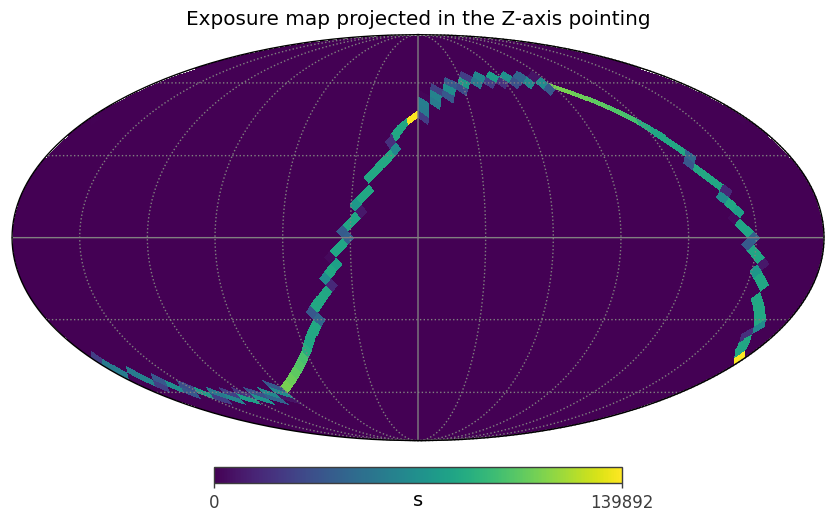

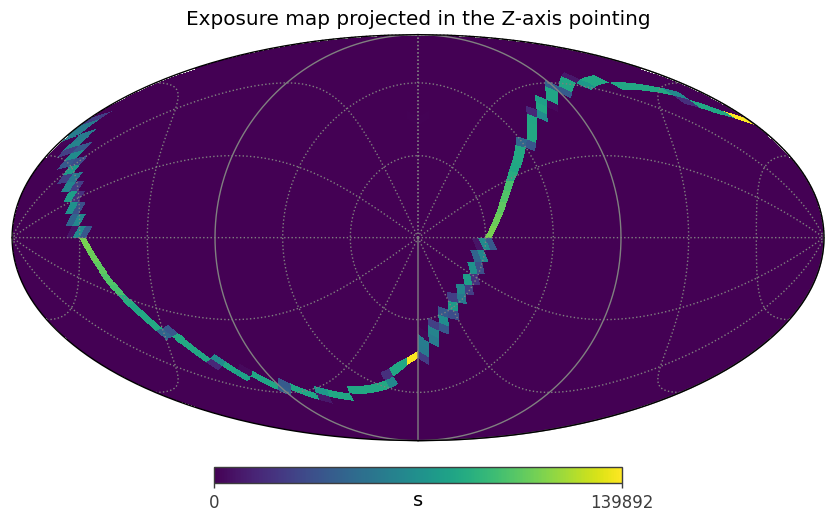

In [11]:
hp.mollview(map_pointing_zx.project('z').contents, rot=(0,0), unit = u.s, title = "Exposure map projected in the Z-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

hp.mollview(map_pointing_zx.project('z').contents, rot=(0,90), unit = u.s, title = "Exposure map projected in the Z-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

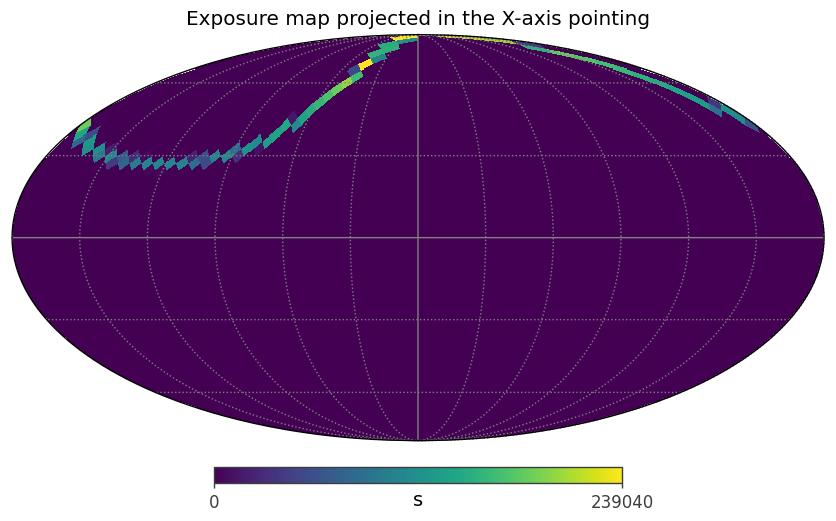

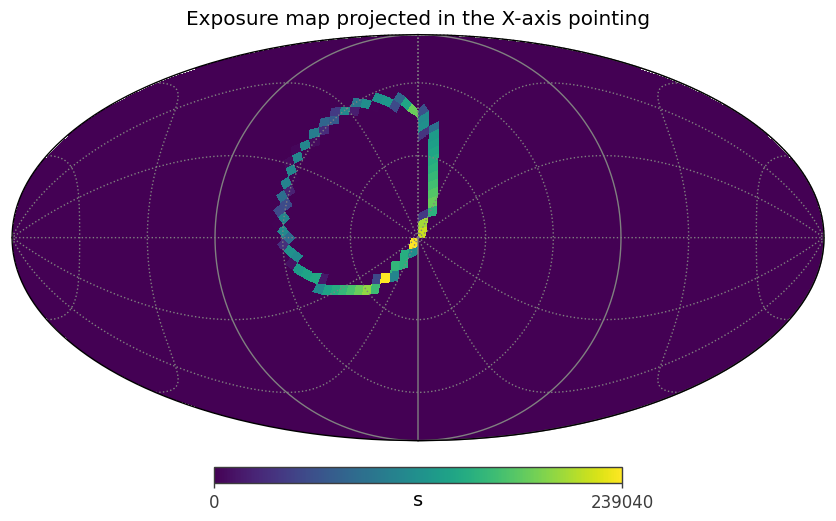

In [12]:
hp.mollview(map_pointing_zx.project('x').contents, rot=(0,0), unit = u.s, title = "Exposure map projected in the X-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

hp.mollview(map_pointing_zx.project('x').contents, rot=(0,90), unit = u.s, title = "Exposure map projected in the X-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

# 2. Calculate the coordinate conversion matrix

CoordsysConversionMatrix.spacecraft_attitude_binning_ccm can produce the coordinate conversion matrix for the spacecraft attitude binning.

In this calculation, we calculate the exposure time map in the detector coordinate for each model pixel and each scatt_binning_index. We refer to it as the dwell time map.

If use_averaged_pointing is True, first the averaged Z- and X-pointings are calculated (the average of zpointing or xpointing in the exposure table) for each scatt_binning_index, and then the dwell time map is calculated assuming the averaged pointings for each model pixel and each scatt_binning_index.

If use_averaged_pointing is False, the dwell time map is calculated for each attitude in zpointing and xpointing (basically every 1 second), and then the calculated dwell time maps are summed up for each model pixel and each scatt_binning_index. 

In the former case, the computation is fast but may lose the angular resolution. In the latter case, the conversion matrix is more accurate, but it takes a very long time to calculate it.

In [13]:
%%time

nside_model = nside_local

coordsys_conv_matrix = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, nside_model = nside_model, use_averaged_pointing = True)

  0%|          | 0/278 [00:00<?, ?it/s]

CPU times: user 11min 16s, sys: 5.89 s, total: 11min 21s
Wall time: 11min 20s


You can save CoordsysConversionMatrix as a hdf5 file.

In [14]:
coordsys_conv_matrix.write("ccm.hdf5", overwrite = True)

You can also read the saved file.

In [15]:
coordsys_conv_matrix = CoordsysConversionMatrix.open("ccm.hdf5")

# 3. produce the binned data

Using the exposure table, we can produce the binned data. Note that here we generate the binned histogram manually. We consider implementing this functionality in the DataIO class in the future.

In [16]:
def get_binned_data_scatt(unbinned_event, exposure_table, psichi_binning = 'local', sparse = False):
    exposure_dict = {row['healpix_index']: row['scatt_binning_index'] for _, row in exposure_table.iterrows()}
        
    # from BinnedData.py
 
    # Get energy bins:
    energy_bin_edges = np.array(unbinned_event.energy_bins)
    
    # Get phi bins:
    number_phi_bins = int(180./unbinned_event.phi_pix_size)
    phi_bin_edges = np.linspace(0,180,number_phi_bins+1)
    
    # Define psichi axis and data for binning:
    if psichi_binning == 'galactic':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = 'galactic', label='PsiChi')
        coords = SkyCoord(l=unbinned_event.cosi_dataset['Chi galactic']*u.deg, b=unbinned_event.cosi_dataset['Psi galactic']*u.deg, frame = 'galactic')
    if psichi_binning == 'local':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = SpacecraftFrame(), label='PsiChi')
        coords = SkyCoord(lon=unbinned_event.cosi_dataset['Chi local']*u.rad, lat=((np.pi/2.0) - unbinned_event.cosi_dataset['Psi local'])*u.rad, frame = SpacecraftFrame())

    # Define scatt axis and data for binning
    n_scatt_bins = len(exposure_table)
    scatt_axis = Axis(np.arange(n_scatt_bins + 1), label='ScAtt')
    
    is_nest = True if exposure_table.scheme == 'nested' else False
    
    nside_scatt = exposure_table.nside
    
    zindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)
    xindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)    
    scatt_data = np.array( [ exposure_dict[(z, x)] + 0.5 if (z,x) in exposure_dict.keys() else -1 for z, x in zip(zindex, xindex)] ) # should this "0.5" be needed?
    
    # Initialize histogram:
    binned_data = Histogram([scatt_axis,
                              Axis(energy_bin_edges*u.keV, label='Em'),
                              Axis(phi_bin_edges*u.deg, label='Phi'),
                              psichi_axis],
                              sparse=sparse)

    # Fill histogram:
    binned_data.fill(scatt_data, unbinned_event.cosi_dataset['Energies']*u.keV, np.rad2deg(unbinned_event.cosi_dataset['Phi'])*u.deg, coords)    
    
    return binned_data

Load the 511keV data (without background)

In [17]:
%%time

signal_filepath = path_data + "Data/Sources/511_thin_disk_3months.fits.gz"

unbinned_signal = UnBinnedData(input_yaml = "inputs_511keV_DC2.yaml")

unbinned_signal.cosi_dataset = unbinned_signal.get_dict_from_fits(signal_filepath)

binned_signal = get_binned_data_scatt(unbinned_signal, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 7.22 s, sys: 334 ms, total: 7.55 s
Wall time: 7.56 s


Load the background data

In [18]:
%%time

bkg_filepath = path_data + "Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz"

unbinned_bkg = UnBinnedData(input_yaml = "inputs_511keV_DC2.yaml")

unbinned_bkg.cosi_dataset = unbinned_bkg.get_dict_from_fits(bkg_filepath)

binned_bkg = get_binned_data_scatt(unbinned_bkg, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 1min 34s, sys: 4.3 s, total: 1min 39s
Wall time: 1min 39s


Sum up the signal and background data

In [19]:
binned_event = binned_signal + binned_bkg

Save them

In [20]:
binned_event.write("511keV_scatt_binning_DC2_event.hdf5")
binned_bkg.write("511keV_scatt_binning_DC2_bkg.hdf5")

**You can move on the next notebook (511keV-DC2-ScAtt-ImageDeconvolution.ipynb).**